In [1]:
import numpy as np
import torch
import os
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append('../')
from sample_batch_data import get_data_info, get_batch
from signal_propagation import get_gradients

In [2]:
sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

  0%|          | 0/3 [00:00<?, ?it/s]

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_hopper_666/model_1.pt


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  0%|          | 0/50 [00:00<?, ?it/s]

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained


You are using a model of type imagegpt to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at openai/imagegpt-small were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2Model were not initialized from the model checkpoint at openai/imagegpt-small and are newly initialized: ['transformer.h.1.ln_2.bias', 'transformer.h.22.ln_1.bias', 'transformer.h.21.ln_1.bias', 'transformer.h.8.ln_2.bias', 'transformer.h.2.ln_1.bias

Loaded from ../../checkpoints/igpt_medium_hopper_666/model_1.pt


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loaded from ../../checkpoints/dt_medium_hopper_666/model_1.pt


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

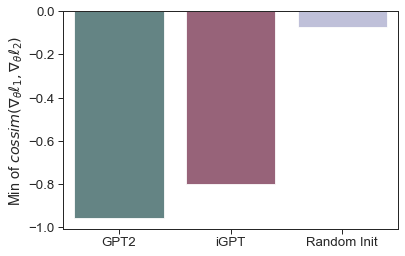

In [4]:
seed=666
epoch=1
env_name='hopper'
dataset_name = 'medium'
env_name = 'hopper'

model_names = ['gpt2', 'igpt', 'dt']
gradcossims_list = []
min_gradcossims_list = []

for model_name in tqdm(model_names):

    torch.manual_seed(seed)

    if model_name == 'gpt2':
        pretrained_lm1 = 'gpt2'
    elif model_name == 'clip':
        pretrained_lm1 = 'openai/clip-vit-base-patch32'
    elif model_name == 'igpt':
        pretrained_lm1 = 'openai/imagegpt-small'
    elif model_name == 'dt':
        pretrained_lm1 = False

    variant = {
        'embed_dim': 768,
        'n_layer': 12,
        'n_head': 1,
        'activation_function': 'relu',
        'dropout': 0.2, # 0.1
        'load_checkpoint': False if epoch==0 else f'../../checkpoints/{model_name}_medium_{env_name}_666/model_{epoch}.pt',
        'seed': seed,
        'outdir': f"checkpoints/{model_name}_{dataset_name}_{env_name}_{seed}",
        'env': env_name,
        'dataset': dataset_name,
        'model_type': 'dt',
        'K': 20,
        'pct_traj': 1.0,
        'batch_size': 50,
        'num_eval_episodes': 100,
        'max_iters': 40,
        'num_steps_per_iter': 2500,
        'pretrained_lm': pretrained_lm1,
        'gpt_kmeans': None,
        'kmeans_cache': None,
        'frozen': False,
        'extend_positions': False,
        'share_input_output_proj': True
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    state_dim, act_dim, max_ep_len, scale = get_data_info(variant)
    states, actions, rewards, dones, rtg, timesteps, attention_mask = get_batch(variant, state_dim, act_dim, max_ep_len, scale, device)
    grads_list = get_gradients(variant, state_dim, act_dim, max_ep_len, states, actions, rewards, rtg, timesteps, attention_mask)
    gradcossim_list = []
    for grads1 in tqdm(grads_list):
        for grads2 in grads_list:
            gradcossim_list.append((torch.dot(grads1, grads2) / (1e-6 + torch.norm(grads1) * torch.norm(grads2))).numpy())
    gradcossim = np.array(gradcossim_list)
    np.save(f'results/gradcossim_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}.npy', gradcossim)

    gradcossims_list.append(gradcossim)

np.save(f'results/gradcossim_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}.npy', gradcossims_list)

min_gradcossims_list = []
for model_name in model_names:
    min_gradcossim = np.min(np.load(f'results/gradcossim_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}.npy'))
    min_gradcossims_list.append([min_gradcossim])

model_name_label = ['GPT2', 'iGPT', 'Random Init']
colors = [(0.372, 0.537, 0.537), (0.627, 0.352, 0.470), (0.733, 0.737, 0.870)]
my_palette = sns.color_palette(colors)
sns.barplot(data=min_gradcossims_list, palette=my_palette)  # "PuBuGn_r"
plt.xticks(np.arange(3), model_name_label)
plt.ylabel(r'Min of $cossim(\nabla_{\theta}\ell_1, \nabla_{\theta}\ell_2)$')
plt.savefig(f'figs/mingradcossim_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}.pdf')
plt.show()

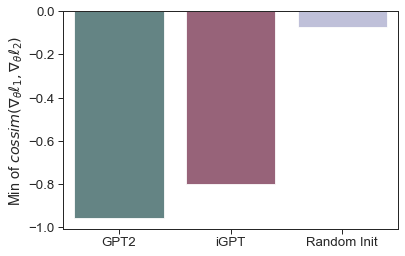

In [5]:
seed=666
epoch=1
env_name='hopper'
dataset_name = 'medium'
env_name = 'hopper'

min_gradcossims_list = []
for model_name in model_names:
    min_gradcossim = np.min(np.load(f'results/gradcossim_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}.npy'))
    min_gradcossims_list.append([min_gradcossim])

model_name_label = ['GPT2', 'iGPT', 'Random Init']
colors = [(0.372, 0.537, 0.537), (0.627, 0.352, 0.470), (0.733, 0.737, 0.870)]
my_palette = sns.color_palette(colors)
sns.barplot(data=min_gradcossims_list, palette=my_palette)  # "PuBuGn_r"
plt.xticks(np.arange(3), model_name_label)
plt.ylabel(r'Min of $cossim(\nabla_{\theta}\ell_1, \nabla_{\theta}\ell_2)$')
plt.savefig(f'figs/mingradcossim_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}.pdf')
plt.show()